In [1]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier


In [2]:
# 2. Load Dataset
df = pd.read_csv(r"C:\Users\aajay\Downloads\archive (3)\creditcard.csv")
# 3. Data Exploration
print("Dataset Shape:", df.shape)
df.head()
print(df['Class'].value_counts())

Dataset Shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


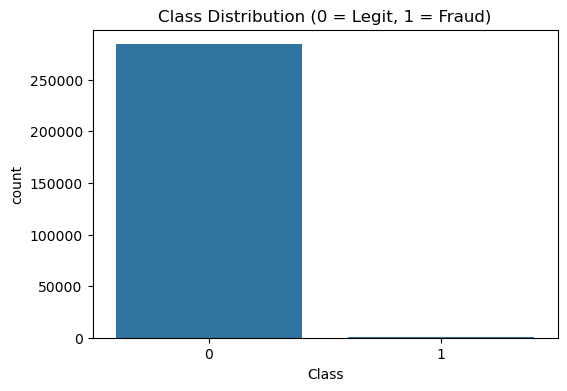

Fraudulent Transactions: 0.1727%


In [ ]:
# 4. Visualization
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legit, 1 = Fraud)')
plt.show()

fraud_ratio = df['Class'].value_counts(normalize=True)[1] * 100
print(f"Fraudulent Transactions: {fraud_ratio:.4f}%")

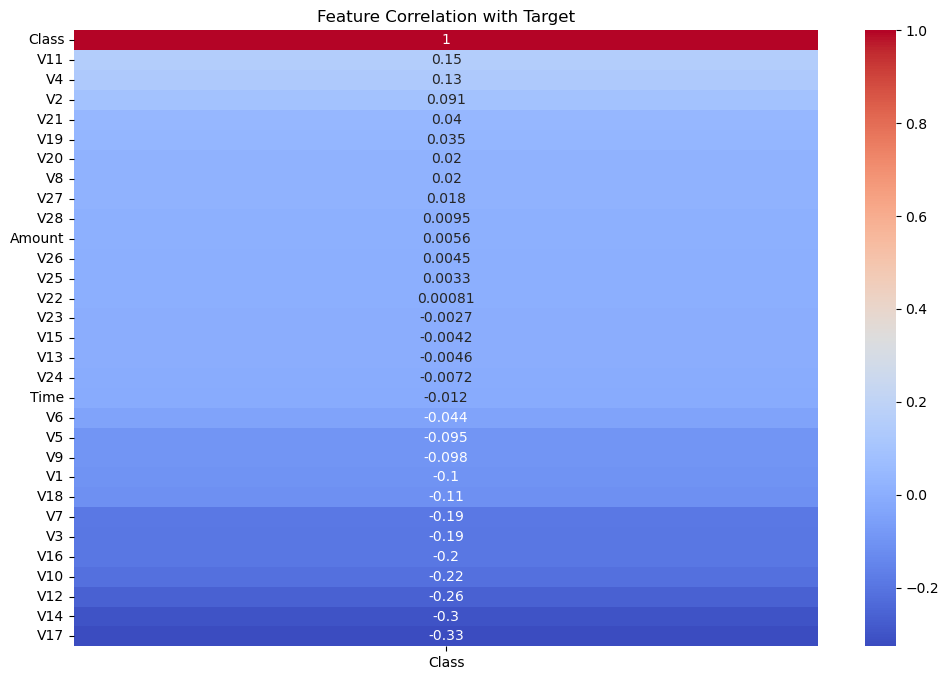

In [4]:
# 5. Correlation Heatmap
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with Target')
plt.show()

In [ ]:
# 6. Preprocessing
df_scaled = df.copy()
df_scaled['Amount'] = StandardScaler().fit_transform(df[['Amount']])
df_scaled = df_scaled.drop(columns=['Time'])  # Time not helpful here

x = df_scaled.drop('Class', axis=1)
y = df_scaled['Class']

In [ ]:
# 7. Train-Test Split (Stratified)
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# 8. Logistic Regression (with class weight)
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(xtrain, ytrain)
y_pred_lr = lr.predict(xtest)

print("** Logistic Regression Report **")
print(classification_report(ytest, y_pred_lr))

** Logistic Regression Report **
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.92      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.95      0.55     56962
weighted avg       1.00      0.97      0.99     56962



In [ ]:
# 9. Random Forest Classifier
# Sample 10% of the data (stratified)

x_sample, _, y_sample, _ = train_test_split(
    xtrain, ytrain, train_size=0.1, stratify=ytrain, random_state=42
)

rf = RandomForestClassifier(class_weight='balanced', random_state=42)
param_rf = {'n_estimators': [100, 200], 'max_depth': [None, 10, 20]}
gs_rf = GridSearchCV(rf, param_rf, cv=5, scoring='f1', n_jobs=-1)
gs_rf.fit(x_sample, y_sample)

best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(xtest)

print("** Random Forest Report **")
print(classification_report(ytest, y_pred_rf))




** Random Forest Report **
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.67      0.76        98

    accuracy                           1.00     56962
   macro avg       0.93      0.84      0.88     56962
weighted avg       1.00      1.00      1.00     56962



In [ ]:
# 10. XGBoost + GridSearch
xgb = XGBClassifier(scale_pos_weight=100, use_label_encoder=False, eval_metric='logloss', random_state=42)
param_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.01, 0.1]
}
gs_xgb = GridSearchCV(xgb, param_xgb, cv=5, scoring='f1', n_jobs=-1)
gs_xgb.fit(xtrain, ytrain)
best_xgb = gs_xgb.best_estimator_
y_pred_xgb = best_xgb.predict(xtest)
print("** XGBoost Report **")
print(classification_report(ytest, y_pred_xgb))


c:\Users\aajay\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:56:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


** XGBoost Report **
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.84      0.86        98

    accuracy                           1.00     56962
   macro avg       0.94      0.92      0.93     56962
weighted avg       1.00      1.00      1.00     56962



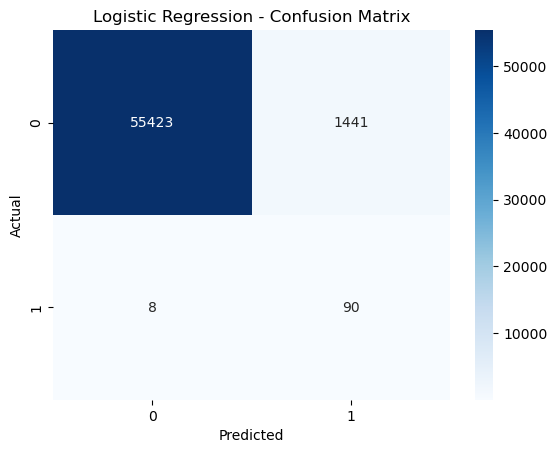

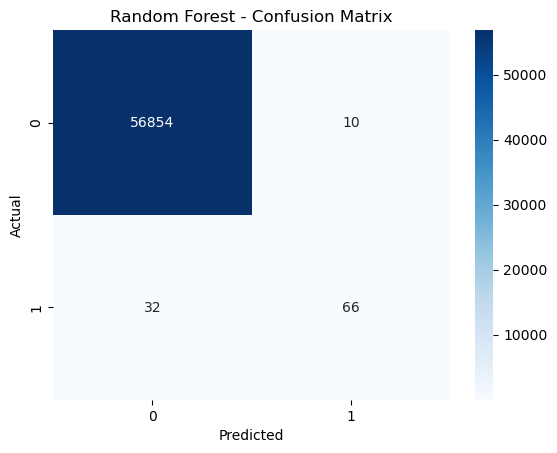

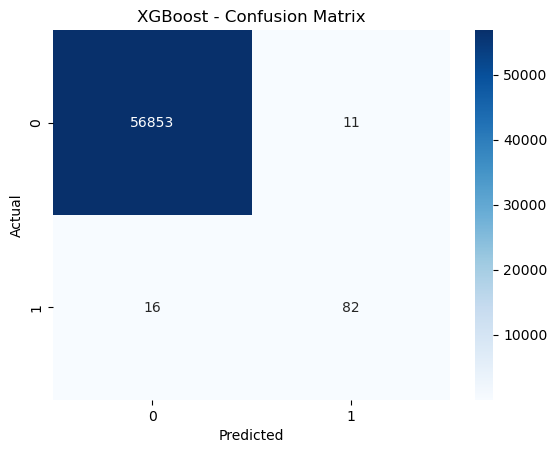

In [ ]:
# 11. Confusion Matrix
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

plot_cm(ytest, y_pred_lr, 'Logistic Regression - Confusion Matrix')
plot_cm(ytest, y_pred_rf, 'Random Forest - Confusion Matrix')
plot_cm(ytest, y_pred_xgb, 'XGBoost - Confusion Matrix')


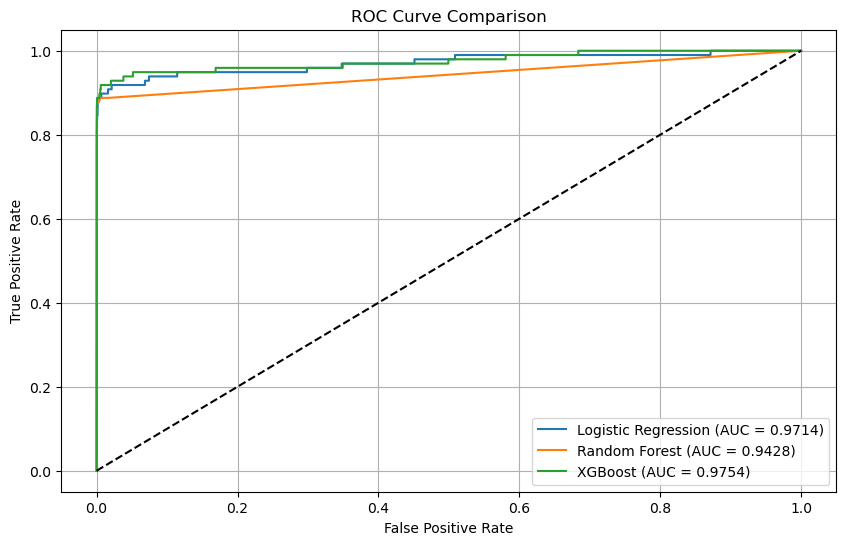

In [ ]:
# 12. ROC Curve
models = {
    'Logistic Regression': lr,
    'Random Forest': best_rf,
    'XGBoost': best_xgb
}

plt.figure(figsize=(10,6))

for name, model in models.items():
    # Predict probabilities
    y_probs = model.predict_proba(xtest)[:, 1]

    # Compute ROC
    fpr, tpr, _ = roc_curve(ytest, y_probs)
    auc = roc_auc_score(ytest, y_probs)

    # Plot
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

# Diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 13. Final Notes
print("\n✔ XGBoost gave the best F1-score and AUC.")
print("✔ Logistic Regression and Random Forest also performed well with class_weight handling.")
print("✔ Cross-validation and hyperparameter tuning improved generalization.")



✔ XGBoost gave the best F1-score and AUC.
✔ Logistic Regression and Random Forest also performed well with class_weight handling.
✔ Cross-validation and hyperparameter tuning improved generalization.
